# Concrete crack detection

This notebook purpose to build a proof of concept of a computer vision model, based on pre-trained deep learning models, to detect cracks in walls. This PoC would be usefull to prove the capability of a AI approach for construction engineering reports - which are mandatory in Brazil - and could pontentially decrease the cost and time spent by specialized people (engineers) to proof the safety or detect risks in building's frontage.

This model will be constructe with open data and based on some already documented sources. Posteriorly, it will be necessary to retrain the model with proprietary images, since this open data images comes from a very different distribution than the real images wich will be done with drones and might have windows, textures, balconies and other specificities.

The model will be built using pytorch framework and the train will be done inside a Azure Machine Learning Studio with a compute engine with GPU.

Train data set available in:
- https://data.mendeley.com/datasets/5y9wdsg2zt/2

Sources:
- https://github.com/priya-dwivedi/Deep-Learning/blob/master/crack_detection/Crack%20Detection%20Model.ipynb
- https://towardsdatascience.com/detection-of-surface-cracks-in-concrete-structures-using-deep-learning-f8f85cd8ac8b
- https://www.researchgate.net/publication/326125873_Concrete_Cracks_Detection_Based_on_Deep_Learning_Image_Classification/fulltext/5b819380a6fdcc5f8b66c195/326125873_Concrete_Cracks_Detection_Based_on_Deep_Learning_Image_Classification.pdf?origin=publication_detail
- https://www.sciencedirect.com/science/article/pii/S1877705817304289
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6864448/#!po=0.862069
- http://www.i-asem.org/publication_conf/asem19/5.SS/ZP.1.SS2321_5719F6.pdf
- https://onlinelibrary.wiley.com/doi/full/10.1111/mice.12564
- https://github.com/topics/crack-detection
- https://arxiv.org/pdf/1908.04392.pdf
- https://www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XLII-2/829/2018/isprs-archives-XLII-2-829-2018.pdf
- http://s-space.snu.ac.kr/bitstream/10371/153261/1/29.pdf

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import datetime
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style(style='darkgrid')
%matplotlib inline

### Auxiliary functions

In [3]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [4]:
def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

In [5]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

### Tranforms

Built a class with a pipeline of transformations to be applied on images to increase the diversity of the dataset

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

In [78]:
#transformations=transforms.Compose([transforms.RandomRotation(30),
#                                    transforms.RandomHorizontalFlip(),
#                                    torchvision.transforms.Grayscale(3),
#                                    transforms.ToTensor()])
#                                    #,transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])
transformations = transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.ColorJitter(brightness=0.15, contrast=0.15),
        torchvision.transforms.Grayscale(3),
        transforms.ToTensor(),
        #transforms.Normalize(mean_nums, std_nums)
])

In [89]:
data_dir="Dataset_full"

dataset=torchvision.datasets.ImageFolder(data_dir,
                                 transform=transformations)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [90]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True,num_workers=4)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=True,num_workers=4)

tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0])
tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0])
tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0])
tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0])


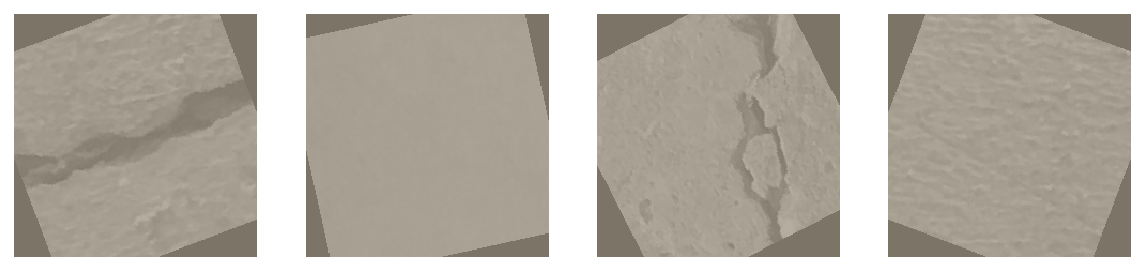

In [91]:
# change this to the trainloader or testloader 
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    print(labels[ii])
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)

tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1])
tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1])
tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1])
tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1])


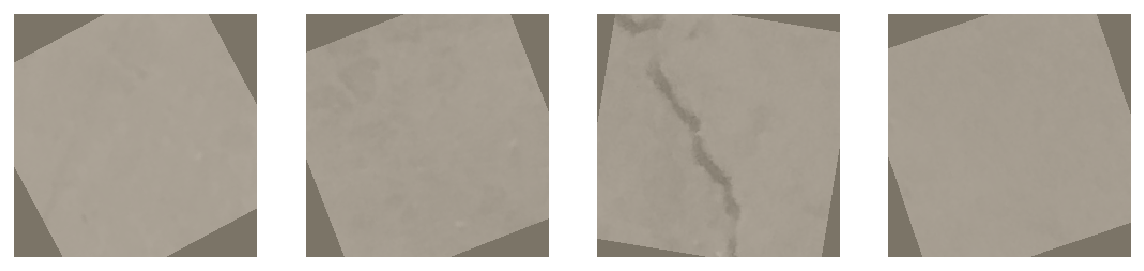

In [92]:
# change this to the trainloader or testloader 
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    print(labels[ii])
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Built the model

In [94]:
resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

## Change the final layer of the resnet model
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)

# Convert model to be used on GPU
resnet50 = resnet50.to(device)

from torchsummary import summary
print(summary(resnet50, (3, 227, 227)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256,

In [95]:
criterion = nn.CrossEntropyLoss() #nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [96]:
from azureml.core import Workspace
from azureml.core import Run
from azureml.core import Experiment
from azureml.core import Model

ws = Workspace.from_config()
experiment = Experiment(workspace = ws, name = "concrete_crack_001")

Due the snapshot of az-ml, it is important to set a file `.amlignore` to ignore the files to be in the snapshot

In [97]:
%%writefile ./.amlignore
Dataset_full*

Define train function.

In [ ]:
def train_model(epochs,model,optimizer,criterion,device,scheduler=None,run,model_name):
    run = experiment.start_logging()
    print("Starting experiment:", experiment.name)
    run.log('Observations', len(dataset))
    run.log('Train_Size', train_size)
    run.log('Test_Size', test_size)
    
    positive_train = cwd + "/Dataset_full/Positive/"
    negative_train = cwd + "/Dataset_full/Negative/"
    
    positive_files = os.listdir(positive_train)
    negative_files = os.listdir(negative_train)
    run.log('Positive_files', len(positive_files))
    run.log('Negative_files', len(negative_files))

    steps = 0
    train_losses, test_losses,test_accuracy = [], [],[]
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for e in range(epochs):
        ini_time=datetime.datetime.now()
        running_loss = 0
        for images, labels in trainloader:
            images=images.to(device)
            labels=labels.to(device)
            
            optimizer.zero_grad()
            if scheduler not None:
                scheduler.step()
            
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        else:
            test_loss = 0
            accuracy = 0
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                for images, labels in testloader:
                    images=images.to(device)
                    labels=labels.to(device)
                    log_ps = model(images)
                    test_loss += criterion(log_ps, labels)
                    
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
                    
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            test_accuracy.append(accuracy/len(testloader))
            
            if (test_loss/len(testloader)) > best_acc:
                best_acc = (test_loss/len(testloader))
                best_model_wts = copy.deepcopy(model.state_dict())
                
            end_time=datetime.datetime.now()
            
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)),
                  "O treinamento demorou desta epoch demora: {}".format(end_time-ini_time))
            
    torch.save({'epochs':epochs,
                'model_state_dict':best_model_wts,
                'optimizer_state_dict':optimizer.state_dict(),
                'loss':test_losses},cwd+'/model/'+model_name)
    
    fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,8))
    sns.lineplot(x=range(len(train_losses)),y=train_losses, label='Training loss')
    sns.lineplot(x=range(len(train_losses)),y=[x.item() for x in test_losses], label='Validation loss')
    plt.title("Losses",fontsize=18)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("CrossEntropyLoss")
    plt.legend(frameon=False)
    
    run.log_image(name = 'label distribution', plot = fig)
    run.upload_file(name = 'Positive_example.jpg', path_or_stream = './Dataset_full/Positive/00001.jpg')
    run.upload_file(name = 'Negative_example.jpg', path_or_stream = './Dataset_full/Negative/00001.jpg')
    run.upload_file(name = model_name, path_or_stream = './model/'+model_name)
    run.register_model(model_path=model_name, model_name=model_name,
                       tags={'Training context':'First Estimator'},
                       properties={'Test_CrossEntropyLoss': test_losses[-1].item(),
                                   'Train_CrossEntropyLoss': train_losses[-1],
                                   'Accuracy': (accuracy/len(testloader)).item()})
    run.complete()
    
    return model,best_model_wts,train_losses,test_losses,test_accuracy,fig

Epoch: 1/10..  Training Loss: 0.804..  Test Loss: 0.810..  Test Accuracy: 0.495


Exception ignored in: <function Image.__del__ at 0x000002519F3E0950>
Traceback (most recent call last):
  File "C:\Users\ihfreitas\AppData\Local\Continuum\anaconda3\envs\python37\lib\site-packages\PIL\Image.py", line 633, in __del__
    def __del__(self):
KeyboardInterrupt


Train the model

In [ ]:
resnet50,best_resnet50_wts,train_losses_resnet50,test_losses_resnet50,test_accuracy_resnet50,fig_plot=\
    train_model(30,resnet50,optimizer,criterion,device,run,'resnet50')

In [ ]:
fig_plot

## Training Inception_v3

Inception_v3 it is another CNN architecture that provide a better accuracy with relative small increase in complexity.

In [ ]:
inception_v3 = models.inception_v3(pretrained=True)

# Freeze model parameters
for param in inception_v3.parameters():
    param.requires_grad = False

## Change the final layer of the resnet model
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = inception_v3.fc.in_features
 
inception_v3.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)

# Convert model to be used on GPU
inception_v3 = inception_v3.to(device)

from torchsummary import summary
print(summary(inception_v3, (3, 227, 227)))

In [ ]:
inception_v3,best_inception_v3_wts,train_losses_inception_v3,
test_losses_inception_v3,test_accuracy_inception_v3,fig_plot=\
    train_model(30,resnet50,optimizer,criterion,device,run,'resnet50')

## AutoEncoder

Here a different approach would be tested, instead of train the model to check if a image has a crack or not - wich still would require an input from the speacialist - the idea here is to build a segmentation (as U-Net) and then use the segmentations in a classifier.

A benchmark were done with OpenCV but the accuracy of this were too poor.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.maxPoll1=nn.MaxPool2d(2,1)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.maxPoll2=nn.MaxPool2d(2,1)        
        
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.conv6 = nn.Conv2d(256, 256, 3)
        self.maxPoll3=nn.MaxPool2d(2,1)  
        
        self.conv7 = nn.Conv2d(256, 512, 3)
        self.conv8 = nn.Conv2d(512, 512, 3)
        self.maxPoll4=nn.MaxPool2d(2,1)          

        self.conv9 = nn.Conv2d(512, 256, 3)
        self.conv10 = nn.Conv2d(256, 256, 3)
        self.maxPoll5=nn.MaxPool2d(2,1)
        
        self.conv11 = nn.Conv2d(256, 128, 3)
        self.conv12 = nn.Conv2d(128, 128, 3)
        self.maxPoll6=nn.MaxPool2d(2,1)        
        
        self.conv13 = nn.Conv2d(128, 64, 3)
        self.conv14 = nn.Conv2d(64, 64, 3)
        self.maxPoll7=nn.MaxPool2d(2,1)  
        
        self.conv15 = nn.Conv2d(64, 3, 3)
        self.conv16 = nn.Conv2d(3, 3, 3)
        self.maxPoll8=nn.MaxPool2d(2,1)                  
        
    def forward(self, x):
        x = self.maxPoll1(F.relu(sef.conv2(F.relu(self.conv1(x)))))
        x = self.maxPoll2(F.relu(sef.conv4(F.relu(self.conv3(x)))))
        x = self.maxPoll3(F.relu(sef.conv6(F.relu(self.conv5(x)))))
        x = self.maxPoll4(F.relu(sef.conv8(F.relu(self.conv7(x)))))
        x = self.maxPoll5(F.relu(sef.conv10(F.relu(self.conv9(x)))))
        x = self.maxPoll6(F.relu(sef.conv12(F.relu(self.conv11(x)))))
        x = self.maxPoll7(F.relu(sef.conv14(F.relu(self.conv13(x)))))
        x = self.maxPoll8(F.relu(sef.conv16(F.relu(self.conv15(x)))))
        return x


## Ensemble Model



In [ ]:
class ensemble(nn.Module):
    def __init__(self):
        super().__init__()
        self.model1 = freeze_params(models.inception_v3(pretrained=True))
        self.model2 = freeze_params(models.resnext50_32x4d(pretrained=True))
        self.model3 = freeze_params(models.resnet50(pretrained=True))
        
        self.classifier = nn.Linear(128, 2)
        
    def freeze_params(model)
        for param in model.parameters():
            param.requires_grad = False
        fc_inputs = model.fc.in_features
     
        model.fc = nn.Sequential(
            nn.Linear(fc_inputs, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 2)
            )
        return model

    def forward(self, x):
        x1=self.model1(x.clone())
        x2=self.model1(x.clone())
        x3=self.model1(x)
        
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        x3 = x3.view(x3.size(0), -1)
        x = torch.cat((x1, x2,x3), dim=1)
        
        x = self.classifier(F.relu(x))
        
        return x
